# Data Exploration

Protocol buffer parsing Inspired by
https://stackoverflow.com/questions/38958751/parsing-nyc-transit-mta-historical-gtfs-data-not-realtime

This extracts data from the protobufs manually downloaded from [MTA Alert Archive](http://web.mta.info/developers/data/archives.html)the latest source suggested at:
https://groups.google.com/d/msg/mtadeveloperresources/Whm5XTVINcE/z-LO12ANAAAJ

**NOTE:** You'll first need to download and extract data.  See [Data README](../docs/Data_README.md), [StatusExtractor.ipynb](StatusExtractor.ipynb) and [AlertScraper.ipynb] This expects data to have been downloaded under <code>data/raw/status</code> and <code>data/raw/alerts</code>

In [1]:
import os
import sys
data_dir = '../data/raw/status'
protobuf_dir = '../MTADelayPredict/protobuf'

In [50]:
proto_file = os.path.join(os.path.join(protobuf_dir), 'gtfs-realtime.proto')
! wget -O $proto_file https://developers.google.com/transit/gtfs-realtime/gtfs-realtime.proto

--2020-05-06 20:57:15--  https://developers.google.com/transit/gtfs-realtime/gtfs-realtime.proto
Resolving developers.google.com (developers.google.com)... 172.217.10.110, 2607:f8b0:4006:811::200e
Connecting to developers.google.com (developers.google.com)|172.217.10.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27065 (26K) [None]
Saving to: ‘../MTADelayPredict/protobuf/gtfs-realtime.proto’

../MTADelayPredict/ 100%[===================>]  26.43K  --.-KB/s    in 0.02s   

2020-05-06 20:57:15 (1.31 MB/s) - ‘../MTADelayPredict/protobuf/gtfs-realtime.proto’ saved [27065/27065]



In [51]:
proto_file = os.path.join(os.path.join(protobuf_dir), 'nyct-subway.proto')
! wget -O $proto_file https://api.mta.info/nyct-subway.proto.txt

--2020-05-06 20:57:15--  https://api.mta.info/nyct-subway.proto.txt
Resolving api.mta.info (api.mta.info)... 13.225.205.96, 13.225.205.67, 13.225.205.5, ...
Connecting to api.mta.info (api.mta.info)|13.225.205.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5387 (5.3K) [text/plain]
Saving to: ‘../MTADelayPredict/protobuf/nyct-subway.proto’

../MTADelayPredict/ 100%[===================>]   5.26K  --.-KB/s    in 0s      

2020-05-06 20:57:15 (17.9 MB/s) - ‘../MTADelayPredict/protobuf/nyct-subway.proto’ saved [5387/5387]



In [54]:
! protoc -I $protobuf_dir --python_out=$protobuf_dir $protobuf_dir/nyct-subway.proto $protobuf_dir/gtfs-realtime.proto

[libprotobuf WARNING google/protobuf/compiler/parser.cc:637] No syntax specified for the proto file: nyct-subway.proto. Please use 'syntax = "proto2";' or 'syntax = "proto3";' to specify a syntax version. (Defaulted to proto2 syntax.)


## Examine Alerts

First, fetch the alert from the downloaded alert data.

### Load alert historical data

In [2]:
import pandas as pd
import numpy as np
import os 

In [6]:
alert_dir = '../data/raw/alerts'
alert_df = pd.read_csv(os.path.abspath(os.path.join(alert_dir, 'raw_alerts_12.01.2018_12.31.2018.csv')))
alert_df.index = alert_df.Date.map(pd.to_datetime)
alert_df.drop(columns=['Date'], inplace=True)
alert_df.sort_index(inplace=True)

In [7]:
alert_df.head(10)

,Agency,Subject,Message
Date,,,
2018-12-01 00:25:00,NYC,"UPDATED: MANH, A Trains, NYPD Activity",Northbound A train service has resumed after e...
2018-12-01 00:34:00,NYC,"BKLYN, 2 and 4 Trains, Rail Replacement.",Northbound 2 and 4 trains are running express ...
2018-12-01 00:55:00,NYC,"MANH, 1 Trains, Vandalism.",Northbound 1 trains are delayed while we remov...
2018-12-01 00:57:00,NYC,"UPDATED: MANH, 1 Trains, Vandalism.",Northbound 1 train service has resumed after w...
2018-12-01 00:58:00,NYC,"UPDATED: MANH, 1 Trains, Vandalism.",Northbound 1 trains are no longer delayed afte...
2018-12-01 01:35:00,NYC,"BX, 4 Trains, Track Maintenance.",Southbound 4 trains are bypassing 138 St-Grand...
2018-12-01 01:45:00,NYC,"MANH, 2 Trains, Track Maintenance.",Southbound 2 trains are running express from 9...
2018-12-01 02:21:00,NYC,"MANH, N and Q, Trains, Brakes Activated.",Northbound N and Q trains are holding in stati...
2018-12-01 02:27:00,NYC,"UPDATED: MANH, N and Q, Trains, Brakes Activated.",Northbound N and Q train service has resumed a...


### Load subway gtfs statuses from this time period

Also download stop ID's to make this more easily explorable

In [8]:
!wget -O $data_dir/Stations.csv http://web.mta.info/developers/data/nyct/subway/Stations.csv 
stations_df = pd.read_csv(data_dir + '/Stations.csv')
stations_df.index = stations_df['GTFS Stop ID']

--2020-05-06 19:30:41--  http://web.mta.info/developers/data/nyct/subway/Stations.csv
Resolving web.mta.info (web.mta.info)... 23.38.169.72, 23.38.169.33
Connecting to web.mta.info (web.mta.info)|23.38.169.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘../data/raw/status/Stations.csv’

../data/raw/status/     [ <=>                ]  50.33K  --.-KB/s    in 0.05s   

2020-05-06 19:30:41 (1.01 MB/s) - ‘../data/raw/status/Stations.csv’ saved [51535]



In [9]:
# We are looking for station R16 aka Times Sq - 42 St
stations_df.loc['R16']

Station ID                                11
Complex ID                               611
GTFS Stop ID                             R16
Division                                 BMT
Line                     Broadway - Brighton
Stop Name                   Times Sq - 42 St
Borough                                    M
Daytime Routes                       N Q R W
Structure                             Subway
GTFS Latitude                        40.7547
GTFS Longitude                      -73.9868
North Direction Label        Uptown & Queens
South Direction Label    Downtown & Brooklyn
Name: R16, dtype: object

In [10]:
# Download some other stuff we need for processing data
!wget -O $data_dir/google_transit.zip http://web.mta.info/developers/data/nyct/subway/google_transit.zip
import zipfile
with zipfile.ZipFile(data_dir+'/google_transit.zip') as zf:
    zf.extractall(data_dir+'/google_transit')

--2020-05-06 19:43:28--  http://web.mta.info/developers/data/nyct/subway/google_transit.zip
Resolving web.mta.info (web.mta.info)... 23.38.169.33, 23.38.169.72
Connecting to web.mta.info (web.mta.info)|23.38.169.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘../data/raw/status/google_transit.zip’

../data/raw/status/     [   <=>              ]   4.45M  9.94MB/s    in 0.4s    

2020-05-06 19:43:29 (9.94 MB/s) - ‘../data/raw/status/google_transit.zip’ saved [4663679]



In [11]:
pd.read_csv(data_dir+'/google_transit/stops.txt')

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,101,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,1,NaN
1,101N,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,0,101
2,101S,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,0,101
3,103,NaN,238 St,NaN,40.884667,-73.900870,NaN,NaN,1,NaN
4,103N,NaN,238 St,NaN,40.884667,-73.900870,NaN,NaN,0,103
...,...,...,...,...,...,...,...,...,...,...
1498,S30N,NaN,Tompkinsville,NaN,40.636949,-74.074835,NaN,NaN,0,S30
1499,S30S,NaN,Tompkinsville,NaN,40.636949,-74.074835,NaN,NaN,0,S30
1500,S31,NaN,St George,NaN,40.643748,-74.073643,NaN,NaN,1,NaN
1501,S31N,NaN,St George,NaN,40.643748,-74.073643,NaN,NaN,0,S31


In [12]:
! ls $data_dir/google_transit

agency.txt    calendar_dates.txt  shapes.txt	  stops.txt	 trips.txt
calendar.txt  routes.txt	  stop_times.txt  transfers.txt


## Parse Protobufs
Have a look at what is actually in these messages.

A great writeup of the mta gtfs feed contents can be found here: https://www.residentmar.io/2018/01/29/gtfs-tripify.html

In [3]:
import sys
sys.path.append(os.path.join(data_dir))
import nyct_subway_pb2
import gtfs_realtime_pb2

In [28]:
msg = gtfs_realtime_pb2.FeedMessage()

with open(os.path.join(data_dir, '201812/20181209/gtfs_nqrw_20181209_042657.gtfs'),'rb') as fh:
    msg.ParseFromString(fh.read())

In [30]:
print(msg)

header {
  gtfs_realtime_version: "1.0"
  incrementality: FULL_DATASET
  timestamp: 1544347617
  [nyct_feed_header] {
    nyct_subway_version: "1.0"
    trip_replacement_period {
      route_id: "N"
      replacement_period {
        end: 1544349417
      }
    }
    trip_replacement_period {
      route_id: "W"
      replacement_period {
        end: 1544349417
      }
    }
    trip_replacement_period {
      route_id: "Q"
      replacement_period {
        end: 1544349408
      }
    }
    trip_replacement_period {
      route_id: "R"
      replacement_period {
        end: 1544349404
      }
    }
  }
}
entity {
  id: "16000001"
  trip_update {
    trip {
      trip_id: "020158_N..S"
      start_date: "20181209"
      route_id: "N"
      [nyct_trip_descriptor] {
        train_id: "1N 0318+ QBP/STL"
        is_assigned: true
        direction: SOUTH
      }
    }
    stop_time_update {
      arrival {
        time: 1544347607
      }
      departure {
        time: 1544347607
      

## Extract Wait Times

In [4]:
# relative MTADelayPredict Project
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.path.join('DataExploration.ipynb')))))
from MTADelayPredict.utils import gtfs_loader
from importlib import reload

In [100]:
# Create loaders for loading data in monthly chunks
loader_start = pd.Timestamp('2018-11-01 00:00:00')
loader_end =  pd.Timestamp('2019-02-01 00:00:00')
drange = pd.date_range(start=loader_start, end=loader_end, freq='M')
loaders = []

# Build separate loaders per month
for i,m in enumerate(drange):
    start_date = m.replace(day=1)
    end_date = m.replace(hour=23,minute=59,second=59)
    loader = gtfs_loader.GTFSLoader(data_dir=os.path.join('../data/raw/status'), \
                                train_line='nqrw')
    loaders.append((loader, start_date, end_date))
    

In [103]:
# Load months in a pool and cache to h5
from multiprocessing import Pool
STOP_FILTER = '^R16N$'

def f(args):
    loader, start_date, end_date = args
    loader.load_range(start_date, end_date, stop_filter=STOP_FILTER, verbose=True)
    filename = os.path.join(data_dir, 'status_{:04d}{:02d}.h5'.format(start_date.year, start_date.month))
    loader.stopped_at_df.to_hdf(filename, key='stopped_at')
    loader.next_train_df.to_hdf(filename, key='next_train')
    loader.next_scheduled_arrival_df.to_hdf(filename, key='next_scheduled_arrival')
    
    return "{} - {} Done".format(start_date, end_date)

with Pool(6) as p:
    print(p.map(f, loaders))
    

  0%|                                     |entries:     82decode_errors:      1

Skipped vehicle entity, no stop times trip {
  trip_id: "032175_Q..N"
  start_date: "20190101"
  route_id: "Q"
  [nyct_trip_descriptor] {
    train_id: "1Q 0521 STL/962"
    is_assigned: true
    direction: NORTH
  }
}



  0%|                                     |entries:     40decode_errors:      1

Skipped vehicle entity, no stop times trip {
  trip_id: "032175_Q..N"
  start_date: "20190101"
  route_id: "Q"
  [nyct_trip_descriptor] {
    train_id: "1Q 0521 STL/962"
    is_assigned: true
    direction: NORTH
  }
}



  5%|##                                   |entries:   2262decode_errors:     67Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Process ForkPoolWorker-24:
  File "/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-20:
  File "/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/miniconda3/lib/python3.7/mu

KeyboardInterrupt: 

In [106]:
# Dead code to load montly exported h5 files if you want to cache things
import glob

stopped_at_files = glob.glob(os.path.join(data_dir, 'stopped_at_*.h5'))
next_train_files = glob.glob(os.path.join(data_dir, 'next_train_*.h5'))
next_scheduled_arrival_files = glob.glob(os.path.join(data_dir, 'next_scheduled_*.h5'))
stopped_at_df = pd.concat([pd.read_hdf(f, key='df') for f in stopped_at_files])
next_train_df = pd.concat([pd.read_hdf(f, key='df') for f in next_train_files])
next_scheduled_arrival_df = pd.concat([pd.read_hdf(f, key='df') for f in next_scheduled_arrival_files])

### Calculate time between train departure, and the next train
Only do this between 04:00 and 19:00, as trains run sporadically outside of that date range

In [116]:
new_stops = stopped_at_df[stopped_at_df != stopped_at_df.shift(1)].dropna()
new_stops['time'] = new_stops.index
new_stops.fillna(method='ffill', inplace=True)

time_till_next_obs = pd.DataFrame(columns=['time'])
# There is generally a gap between end of day and start of day, or if there are missing day
# we need to calculate time until next train within each day and not accidentally count overnight
deltas = []
new_stops = new_stops.sort_index()

for _,d in new_stops.groupby(new_stops.index.date):
    deltas.append((d.time.shift(-1) - d.time).to_frame())
#for _,d in new_stops.groupby(new_stops.index.date):
#    time_till_next_obs.loc[d.index, 'time'] = d.time.shift(-1) - d.time

time_till_next_obs = pd.concat(deltas)
time_till_next_obs = time_till_next_obs.dropna(how='all')
time_till_next_obs = time_till_next_obs.between_time('04:00','19:00')
#time_till_next_obs = (new_stops.time.shift(-1) - new_stops.time).to_frame()
time_till_next_obs['minutes'] = time_till_next_obs['time'].map(lambda x: x.total_seconds() / 60. )


In [117]:
time_till_next_obs.minutes.describe()

count    79383.000000
mean         1.624860
std          2.245171
min          0.016667
25%          0.250000
50%          0.750000
75%          2.166667
max         67.766667
Name: minutes, dtype: float64

### Examine train status against alert data

In [120]:
# Find if alerts are predictive
# Get a list of alert times for N train

alert_dir = '../data/raw/alerts'
alert_files = glob.glob(os.path.abspath(os.path.join(alert_dir, 'raw_alerts_*.csv')))
alert_list = []
for f in alert_files:
    alert_list.append(pd.read_csv(f))
alert_df = pd.concat(alert_list)
alert_df.index = alert_df.Date.map(pd.to_datetime)
alert_df.drop(columns=['Date'], inplace=True)
alert_df.sort_index(inplace=True)

In [122]:
# Train wait time
train_wait = time_till_next_obs.replace(0, np.nan).dropna().minutes

In [130]:
# Create a mask for all train wait times for MINUTE_DURATION minutes after an alert arrives

import progressbar
train_wait 
# Only get N train alerts
train_alerts = alert_df.loc[alert_df.Subject.str.match(r'.* N(?:(, )|( and)).*')]
# Consider the observed waits for the next MINUTE_DURATION after an alert as affected 
MINUTE_DURATION = 30

alert_mask = pd.DataFrame(index=train_wait.index, columns=['alerted'])
alert_mask[:] = False
widgets = [progressbar.Percentage(), progressbar.Bar()]
bar = progressbar.ProgressBar(widgets=widgets, max_value=len(alert_df.index), min_poll_interval=.5).start()

for i,t in enumerate(train_alerts.loc[train_wait.index[0]:train_wait.index[-1]].index):
    ts = pd.Timestamp(t, tz='US/Eastern')
    alert_mask.loc[ts:ts+pd.Timedelta(MINUTE_DURATION, unit='m')] = True
    bar.update(i+1)
bar.finish()

100%|#########################################################################|


In [131]:
train_alerts.shape

(2324, 3)

In [132]:
train_wait.autocorr()

0.40519850559788534

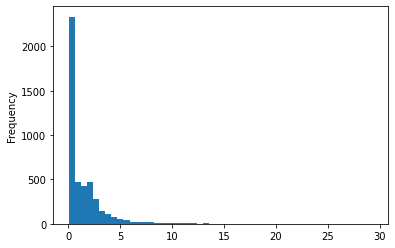

In [133]:
train_wait[alert_mask.alerted].dropna().plot.hist(bins=50)

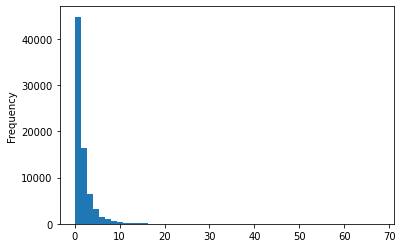

In [134]:
train_wait[~alert_mask.alerted].dropna().plot.hist(bins=50)

In [135]:
from scipy.stats import ttest_ind

ttest_ind(train_wait[alert_mask.alerted].dropna(), train_wait[~alert_mask.alerted].dropna())


Ttest_indResult(statistic=-6.098350197557383, pvalue=1.0766137773020761e-09)

In [136]:
from scipy.stats import ks_2samp
print(ks_2samp(train_wait[alert_mask.alerted].dropna(), train_wait[~alert_mask.alerted].dropna(), alternative='greater'))

Ks_2sampResult(statistic=0.04238592552107179, pvalue=1.9054404000886412e-07)
